In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from Bio import PDB
import seaborn as sns

#### This notebook combines the structural predictions with ESMFold and identified phosphosites. It checks if phosphosites are enriched for in intrinsically disordered regions (low pLDDT).

In [2]:
# get phosphosites from PeptideAtlas
mods = pd.read_csv("../data/Fig5_Modifications/Suppl_Table_2_Modification_Sites.tsv", sep="\t")
phosphos = mods[(mods["Modification"] == "Phospho") & (mods["unimod_classification"] == "Post-translational")]
phosphos = phosphos.rename(columns={"protein_id": "protein", "mod_pos_in_protein": "position", "Modified_Amino_Acid": "residue"})

In [3]:
# helperfunctions

aa_3to1 = {
    "ALA": "A", "CYS": "C", "ASP": "D", "GLU": "E", "PHE": "F",
    "GLY": "G", "HIS": "H", "ILE": "I", "LYS": "K", "LEU": "L",
    "MET": "M", "ASN": "N", "PRO": "P", "GLN": "Q", "ARG": "R",
    "SER": "S", "THR": "T", "VAL": "V", "TRP": "W", "TYR": "Y"
}

def pdb_to_dataframe(pdb_file):
    """
    Parses a PDB file and extracts atom identifier, residue name, and B-factor
    into a pandas DataFrame.

    Parameters:
    pdb_file (str): Path to the PDB file.

    Returns:
    pd.DataFrame: DataFrame containing columns 'Atom', 'Residue', and 'B-factor'.
    """
    # Initialize the PDB parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)

    protein_id = str(pdb_file).split("/")[-1].split(".")[0].split("_part")[0]

    # Prepare a list to hold data for each atom
    data = []
    partial_protein_sequence = []
    position = 0

    # Iterate over all models, chains, and residues in the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    # Append the one-letter code for the amino acid to the sequence
                    partial_protein_sequence.append(residue.get_resname())
                for atom in residue:
                    # Extract atom identifier, residue name, and B-factor
                    residue_name = residue.get_resname()
                    # Convert 3-letter code to 1-letter code
                    residue_name = aa_3to1.get(residue_name, residue_name)
                    plddt = atom.get_bfactor()

                    # Append the data to the list
                    data.append([residue_name, plddt, position])
                position += 1

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data, columns=["residue", "plddt", "position"])

    # aggregate to residue level
    df = df.groupby(["residue", "position"]).agg({"plddt": "median"}).reset_index().sort_values(by=["position"])

    if "part2" in str(pdb_file):
        # add 800 to the position
        df["position"] = df["position"] + 800

    # create a new column with the protein id
    df["protein_id"] = protein_id
    # create a new column with the protein sequence
    df["protein_sequence"] = partial_protein_sequence

    return df


def alphafold_pdb_to_dataframe(pdb_file):
    """
    Parses a PDB file and extracts atom identifier, residue name, and B-factor
    into a pandas DataFrame.

    Parameters:
    pdb_file (str): Path to the PDB file.

    Returns:
    pd.DataFrame: DataFrame containing columns 'Atom', 'Residue', and 'B-factor'.
    """
    # Initialize the PDB parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)

    protein_id = str(pdb_file).split("/")[-1].split(".")[0].split("-")[1]

    # Prepare a list to hold data for each atom
    data = []

    # Iterate over all models, chains, and residues in the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    # Extract atom identifier, residue name, and B-factor
                    atom_name = atom.get_name()
                    if atom_name == "CA":
                        # Only consider alpha carbon atoms (all atoms have the same plddt anyways)
                        residue_name = residue.get_resname()
                        # Convert 3-letter code to 1-letter code
                        residue_name = aa_3to1.get(residue_name, residue_name)
                        plddt = atom.get_bfactor()

                        # Append the data to the list
                        data.append([residue_name, plddt])

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data, columns=["residue", "plddt"])

    # create a new column with the protein id
    df["protein"] = protein_id

    df["position"] = df.index

    return df


In [6]:
# parse pdb files into tables
pdb_files = Path("../data/SupplFig4_plDDT_phospho_analysis/").rglob("ESMFold_predictions*/*.pdb")
protein_table = pd.DataFrame()

for pdbfile in pdb_files:
    # parse the pdb file
    df = pdb_to_dataframe(pdbfile)
    df["protein_id"] = pdbfile.stem
    protein_table = pd.concat([protein_table, df], ignore_index=True)

protein_table

,residue,position,plddt,protein_id,protein_sequence
0,M,0,78.32,P77324,MET
1,K,1,83.30,P77324,LYS
2,A,2,88.79,P77324,ALA
3,F,3,89.24,P77324,PHE
4,T,4,92.22,P77324,THR
...,...,...,...,...,...
1592816,N,402,91.17,P32057,ASN
1592817,D,403,90.29,P32057,ASP
1592818,I,404,86.40,P32057,ILE
1592819,R,405,77.75,P32057,ARG


In [5]:
# take the max pLDDT for each residue (some are duplicatated due to overlap)
protein_table["protein"] = protein_table["protein_id"].str.split("_part").str[0]
amino_acids_with_plddts = protein_table.groupby(["protein", "residue", "position"]).agg({"plddt": "max"}).reset_index()
amino_acids_with_plddts = amino_acids_with_plddts.merge(phosphos, how="left", on=["protein", "position", "residue"])
amino_acids_with_plddts

,protein,residue,position,plddt,Modification,unimod_classification,unimod_id
0,A0A0H2XIX4,A,3,77.910,NaN,NaN,NaN
1,A0A0H2XIX4,A,23,65.680,NaN,NaN,NaN
2,A0A0H2XIX4,A,25,59.420,NaN,NaN,NaN
3,A0A0H2XIX4,A,26,61.590,NaN,NaN,NaN
4,A0A0H2XIX4,A,34,84.030,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1673631,UPI000501A50D,Y,586,90.720,NaN,NaN,NaN
1673632,UPI000501A50D,Y,595,94.560,NaN,NaN,NaN
1673633,UPI000501A50D,Y,612,92.125,NaN,NaN,NaN
1673634,UPI000501A50D,Y,693,97.780,NaN,NaN,NaN


Text(0.5, 1.0, 'pLDDT Distribution for Different Residue Types')

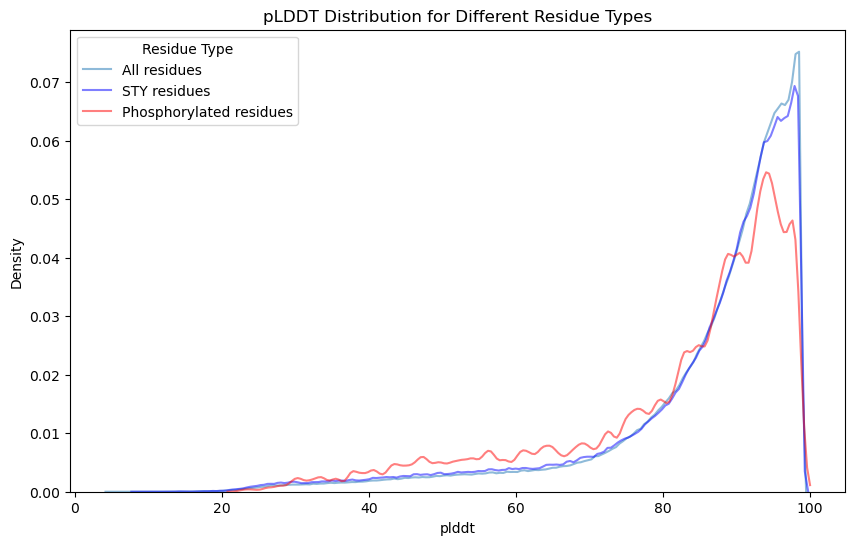

In [6]:
# plot density of plddt
plt.figure(figsize=(10, 6))
sns.kdeplot(data=amino_acids_with_plddts, x="plddt", common_norm=False, fill=False, alpha=0.5, bw_adjust=0.2, label="All residues")

# add density for all STYs
sns.kdeplot(data=amino_acids_with_plddts[amino_acids_with_plddts["residue"].isin(["S", "T", "Y"])], x="plddt", common_norm=False, fill=False, alpha=0.5, color="blue", bw_adjust=0.2, clip=(0, 100), label="STY residues")

# add density of plddt for phosphos
sns.kdeplot(data=amino_acids_with_plddts[amino_acids_with_plddts["Modification"] == "Phospho"], x="plddt", common_norm=False, fill=False, alpha=0.5, color="red", bw_adjust=0.2, clip=(0, 100), label="Phosphorylated residues")

# add legend
plt.legend(title="Residue Type", loc="upper left")
plt.title("pLDDT Distribution for Different Residue Types")